Up until this point in the reduction, we have not been able to describe any of our data in terms of wavelength. In order to convert pixel position along the dispersion axis to wavelength, we need to identify known emission lines in an arclamp image.

In this section, we discuss how ```specsuite``` can be used to interactively match two lists of lines.

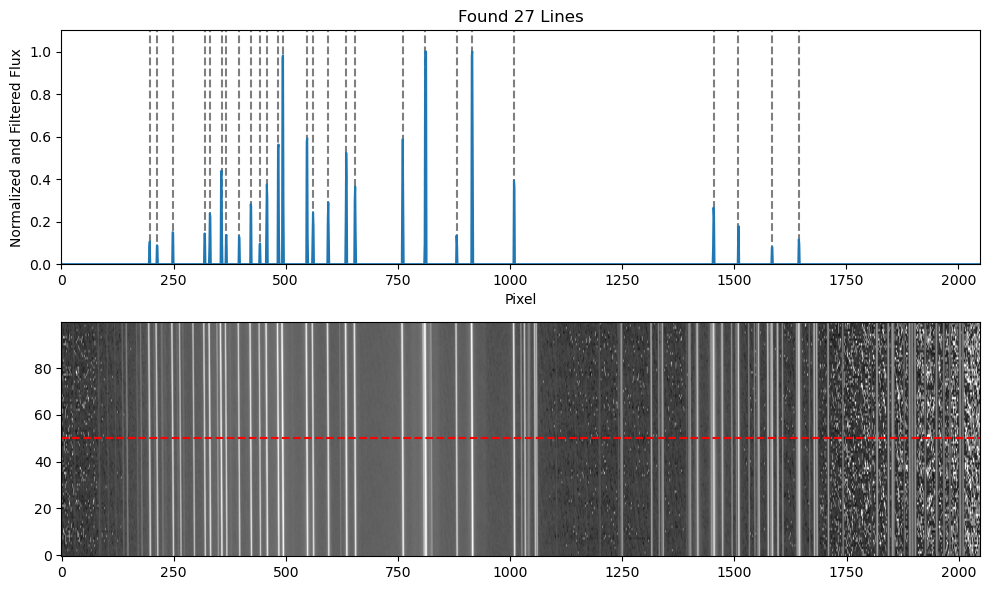

26


In [20]:
import specsuite as ss
import astropy.units as u
import ASDtools as asdt
import numpy as np

# Defines where to look for data
DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
INSTRUMENT = "kosmos"
WAV_BOUNDS = (550 * u.nm, 950 * u.nm)

# Collects all the necessary exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
)

arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
) - bias

arclamp_lines, _ = ss.find_cal_lines(arclamp, std_variation=250, debug=True)

# A list of known emission features for APO's KOSMOS instrument (neon)
known_lines = [
    5852.49, 5881.90, 5944.83, 6030.00, 6096.16, 6143.06, 6266.50, 6334.43, 6382.99, 6402.25,
    6506.53, 6598.95, 6678.28, 6717.04, 6929.47, 6032.41, 7173.94, 7245.17, 7438.90, 7488.87,
    8300.36, 8377.61, 8495.36, 8654.38, 8780.62, 8853.87,
]

print(len(known_lines))


## **Basic Usage**
### _The "Wavcal Widget"_
Since MKDocs can only create static websites, we cannot demonstrate ```specsuite```'s interactive wavelength calibration widget here. We will provide the code necessary for running the widget and provide a series of static images to go along with them. To activate the widget, you need to create an instance of ```WavecalWidget``` with two lists of lines and call the ```.activate_widget()``` function...

In [ ]:
wavecal_widget = ss.WavecalWidget(
    upper_lines = known_lines,
    lower_lines = arclamp_lines,
)

#wavecal_widget.activate_widget()   <--- Uncomment this to initialize the widget

![Initial widget layout](../assets/widget_initial_configuration.png)

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
        Behind the scenes, the widget tried to automatically change the Jupyter notebook backend back and forth from "widget" and "inline". If you notice weird behavior in your plots after using the widget, it is possible that this conversion did not work as intended. You can fix this by including %matplotlib inline at the top of the next cell.
    </p>
</div>

There is a lot to unpack, so let's start by describing the first two plots. Here, you are seeing a visualization of the line lists you provided. The top plot corresponds to ```known_lines```, and the second plot corresponds to ```arclamp_lines```. These images are made by summing several Gaussian distributions with a mean at the line location and a shared standard deviation (we will come back to this). Hopefully you can see some shared pattern in both images, but it can be hard to discern exactly which lines to pair with one another. To help with matching, there are a handful of controls that allow you to modify the widget...

![Initial widget layout](../assets/widget_controls.png)

Let's briefly walk through what each of these buttons do. In the leftmost box...

> - **Reset Buttons**: Resets all changes made to the corresponding line plot. All removed lines will be restored, and all matched pairs will be lost.
> - **Size Sliders**: Adjusts the size of lines (standard deviation) in the corresponding line plot.

In the middle box...

> - **Toggle Intensity**: Controls whether line intensities are used to alter the brightness of the two line plots. If one (or both) line intensity lists were not provided, the related plot will not be affected by this button.
> - **Toggle Matched Fit**: Controls whether to display the wavelength calibration for matched pairs will be displayed.
> - **Undo**: Will revert the last action taken (including matching and removing lines). If pressed multiple times in a row, multiple actions will be undone.
> - **Residual Cap**: The upper and lower bounds on the residual plot (this is the bottom plot).
> - **Fit Order**: The order of polynomial used to fit to matched lines. Note that a valid fit will only be plotted if the number of matched lines is greater than the order of the polynomial plus one.

In the rightmost box...

> - **Remove/Match Button**: Determines the behavior of the widget when the upper two plots are clicked. When on "Remove," the nearest line will be removed. When on "Match," any pair of two lines from the first two plots will be grouped together.
> - **Close Widget Button**: Terminates the widget's interactive behavior.

The best way to familiarize yourself with these controls is to just try it for yourself! However, we can take a look at an example of the widget once a few lines have been "matched up"...

![Initial widget layout](../assets/widget_example.png)

Note how dashed green lines show which lines have been paired, and the bottom three plots are now filled with some useful diagnostic information! In order, these plots show...

> - The current polynomial fit based on your matched lines. Each point represents a single pair of lines where the x-value corresponds with ```lower_lines``` and the y-value corresponds with ```upper_lines```.
> - The derivative of the polynomial fit. Points are linearly interpolated using all matched lines.
> - Residuals between the polynomial fit and all matched lines. The vertical bounds of this plot are controlled by the "Residual Cap" slider.

These plots can help you determine how accurate your current calibration is looking. For example, if one point had an incredibly large residual, that is a potential indication that you made an error. Mistakes can be rectified either by using the "Undo" button (best for recent mistakes) or either of the "Reset" Buttons (for more severe / older mistakes).

Once you have finished matching up lines, you can extract a list of these pairs and the final wavelength solution using the following code...

In [ ]:
paired_lines = wavecal_widget.final_lines # List of all paired lines
p_wavecal = wavecal_widget.p # The final np.polynomial
pdr_wavecal = wavecal_widget.pdr # The final derivative of np.polynomial

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Currently, this is the only part of our reduction pipeline that cannot be automated. However, unless you need to perform additional wavelength-dependent corrections (such as those shown in "Advanced Tools"), this step is not necessary for getting a quick look at your data. We are currently working on an automated routine, but it requires more work and testing before an official release.
    </p>
</div>

## __Common Errors__
### _WavecalWidget is unresponsive_
Under the hood, ```WavecalWidget()``` is trying to use a "magic command" to convert the Jupyeter notebook into an environment that can handle widgets. Specifically, it is attempting to run the equivalent of ```%matplotlib widget```, then converting back to ```%matplotlib inline``` once the widget is closed. These only work in Jupyter-like environments, so any attempt to run this widget will result in an error. If your widget is loading, but is not interactive, try running ```%matplotlib widget``` at the top of your cell. 

In [ ]:
%matplotlib widget

wavecal_widget = ss.WavecalWidget(known_lines, arclamp_lines)
#wavecal_widget.activate_widget()   <----- Uncomment this to initialize the widget

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
        We have found that the widget does not work properly when run on remote servers. This is related to complications in how Jupyter notebooks handle interactivity. If possible, please run this widget locally on your own device.
    </p>
</div>

### _No Lines Being Shown_
Sometimes, the default width of lines is too small. This is caused by the way we are generating the 'simulated images' since the standard deviation depends on the 

In [ ]:
import specsuite as ss
import matplotlib.pyplot as plt
import astropy.units as u

w, f, _ = ss.load_STIS_spectra("1732526")

mask = (6000*u.AA < w) & (w < 9000*u.AA)

w = w[mask]
f = f[mask]

plt.rcParams["figure.figsize"] = (12, 4)
plt.plot(w, f)